# Fold Interpretation

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import sys
sys.path.append('./lib')

import pandas as pd
import numpy as np

In [3]:
from lib.definitions import RANDOM_SEED, numerical_column_names, categorical_column_names, binary_column_names

In [4]:
RANDOM_SEED = 42

import random
random.seed(RANDOM_SEED)

import numpy.random
numpy.random.seed(RANDOM_SEED)

import os
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)

import tensorflow
tensorflow.set_random_seed(RANDOM_SEED)

## 1. Classifier Definition

In [5]:
from lib.classifiers import classifier_factories
from lib.dataset import train_on_splits

best_classifiers = [
    'Random Forest',
    'Naive Bayes',
    'Quadratic Discriminant Analysis'
]

def create_ensemble_estimator(verbose, random_state, n_jobs):
    from sklearn.ensemble import VotingClassifier
    estimators = list(
                map(
                    lambda name: (name, classifier_factories[name](verbose=0, random_state=RANDOM_SEED, n_jobs=-1)),
                    best_classifiers))

    return VotingClassifier(estimators, voting='soft')

In [6]:
configs = train_on_splits(create_ensemble_estimator, verbose=1, random_state=RANDOM_SEED, n_jobs=-1)

## 2. Partial Dependence Plots (PDP)

In [7]:
from lib.xai import plot_pdp_features_per_split

### PDPs for numerical columns


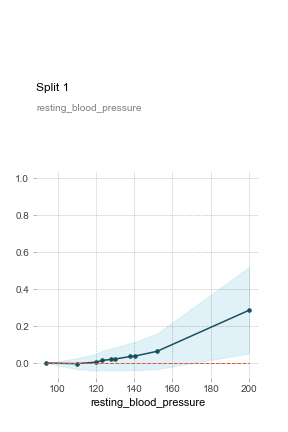
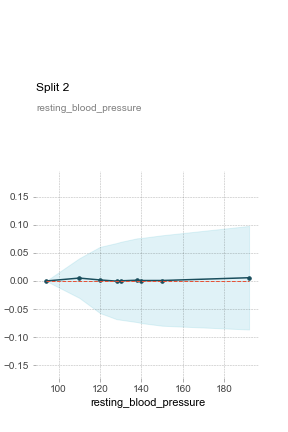
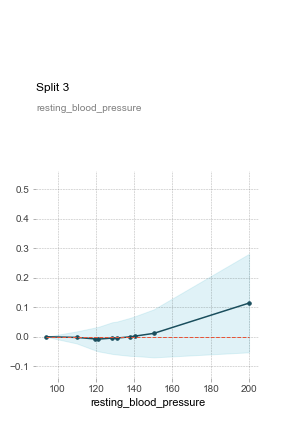
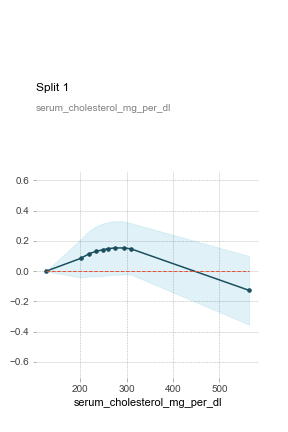
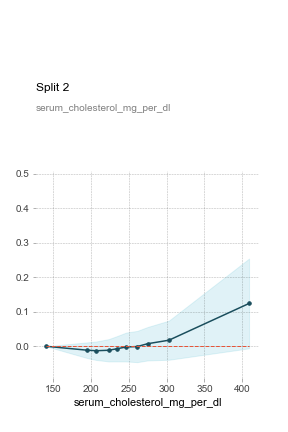
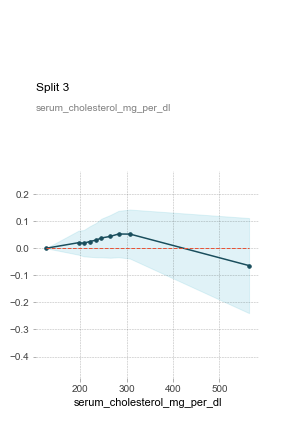
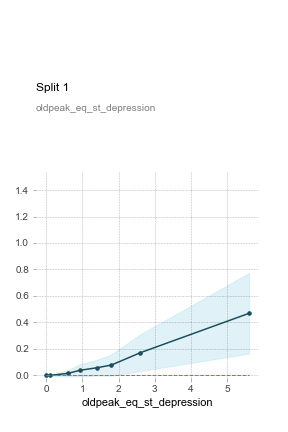
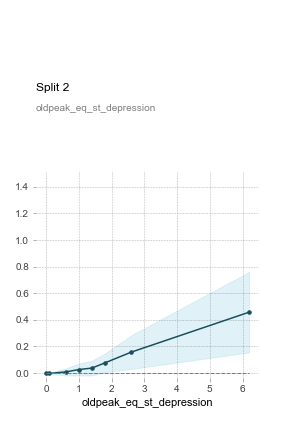
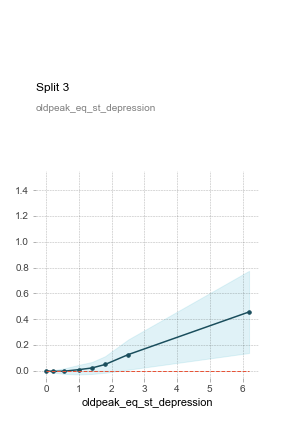
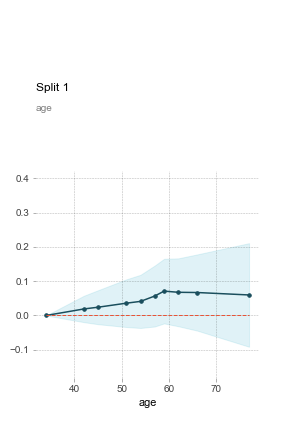
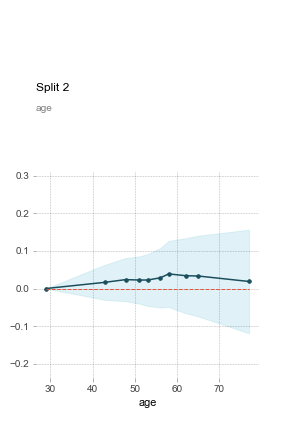
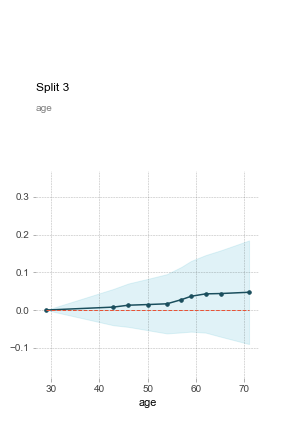
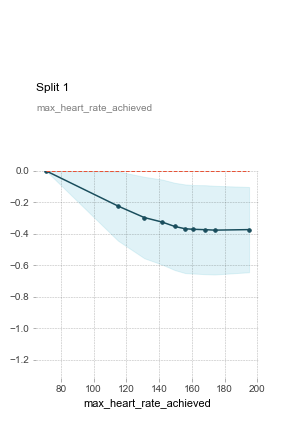
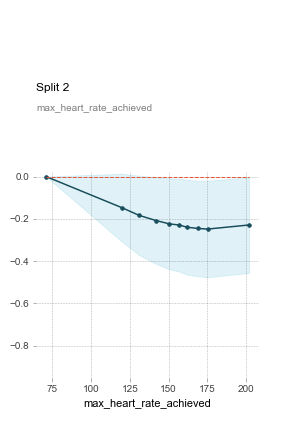
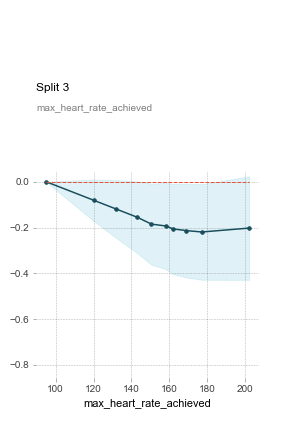

CPU times: user 4.89 s, sys: 436 ms, total: 5.32 s
Wall time: 18.4 s


In [8]:
%time plot_pdp_features_per_split(configs, numerical_column_names)

### PDPs for categorical columns


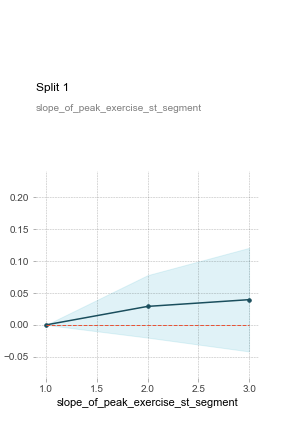
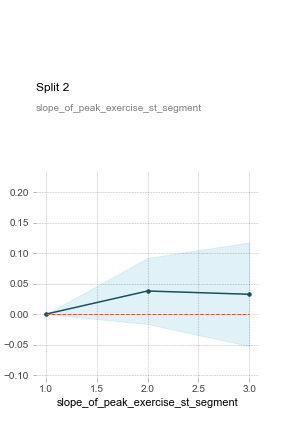
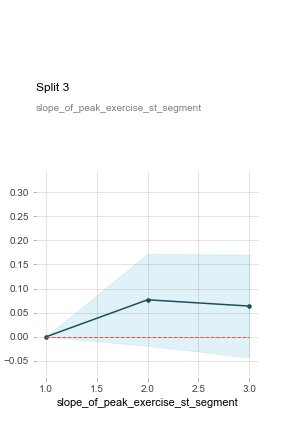
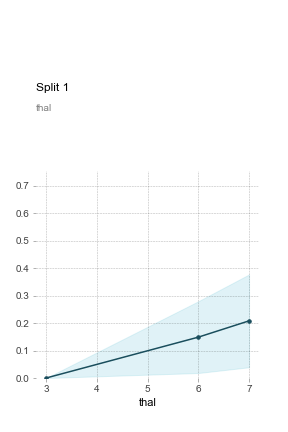
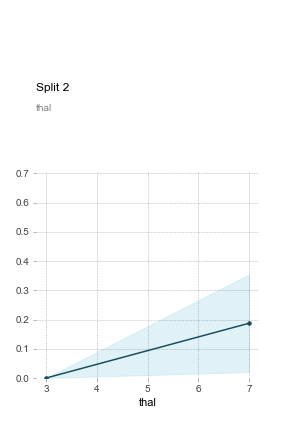
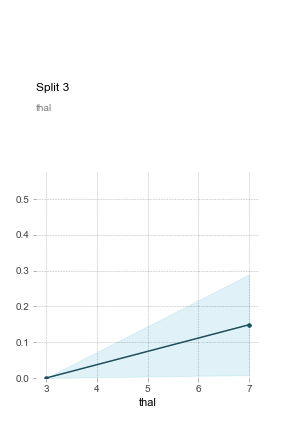
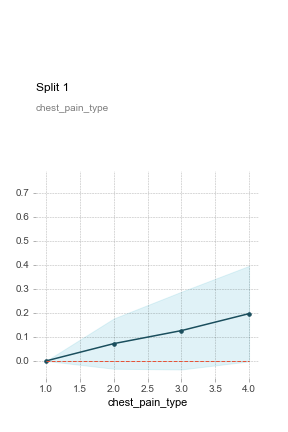
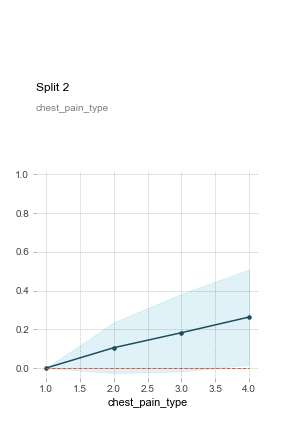
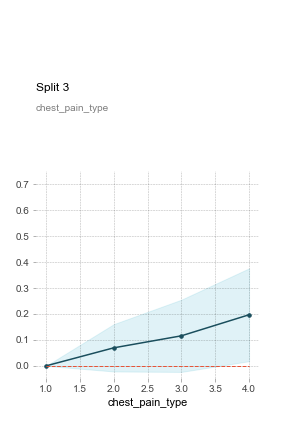
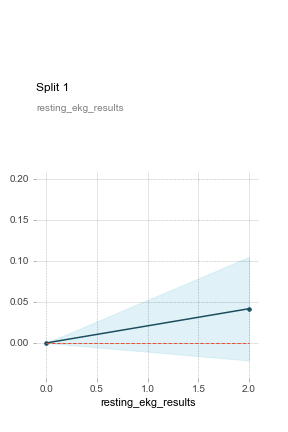
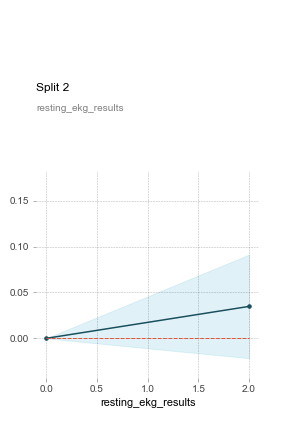
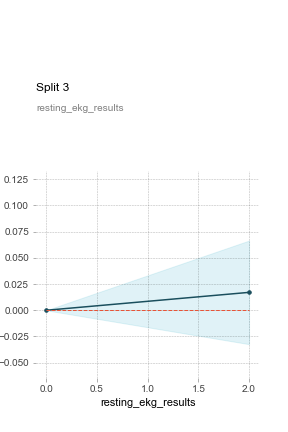
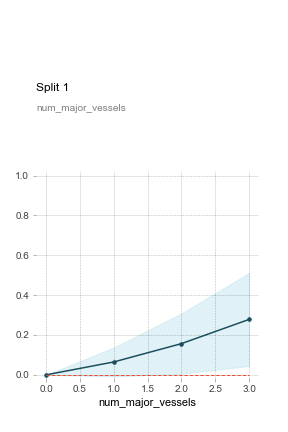
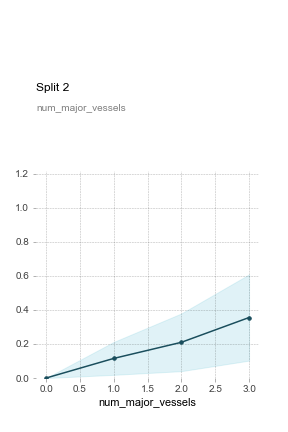
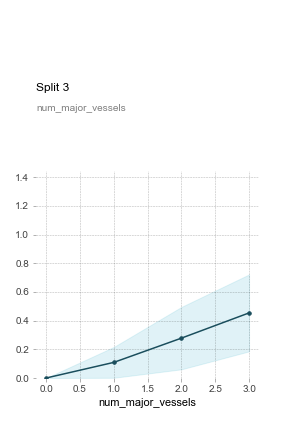

CPU times: user 3.73 s, sys: 243 ms, total: 3.97 s
Wall time: 8.67 s


In [9]:
%time plot_pdp_features_per_split(configs, categorical_column_names)

### PDPs for binary columns


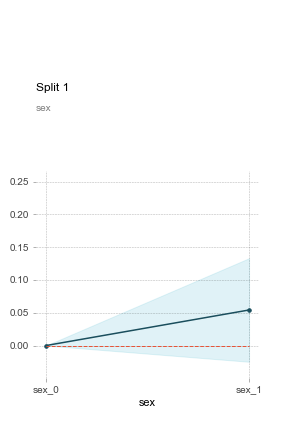
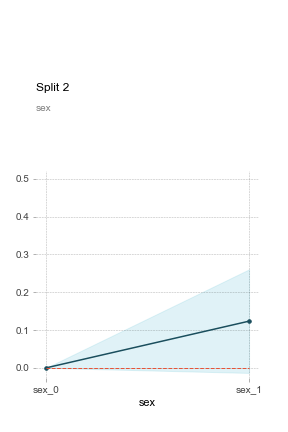
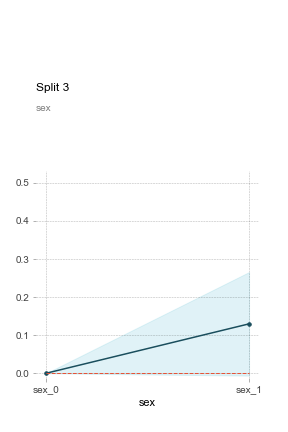
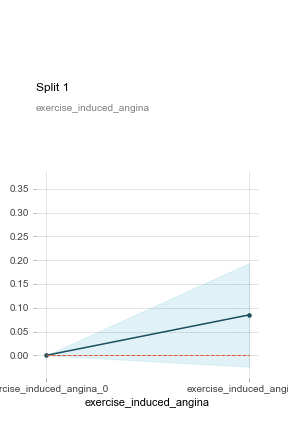
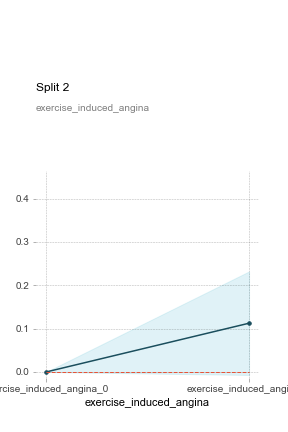
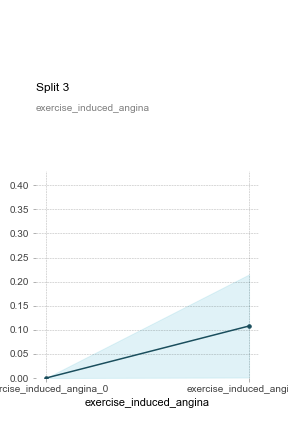
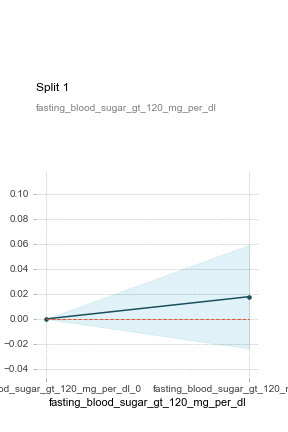
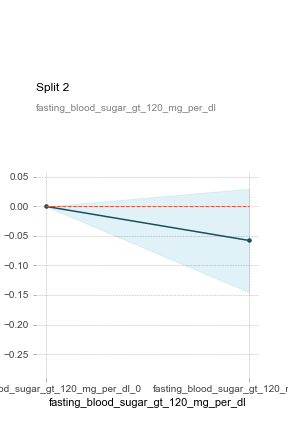
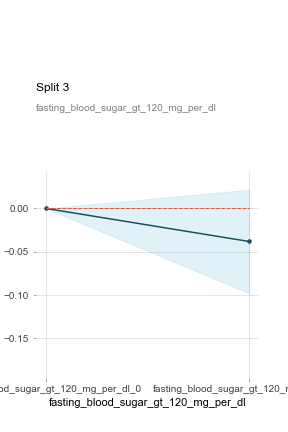

CPU times: user 1.53 s, sys: 83.4 ms, total: 1.61 s
Wall time: 3.5 s


In [10]:
%time plot_pdp_features_per_split(configs, binary_column_names)

## 3. Individual Conditional Expectation (ICE)

### ICEs for numerical columns


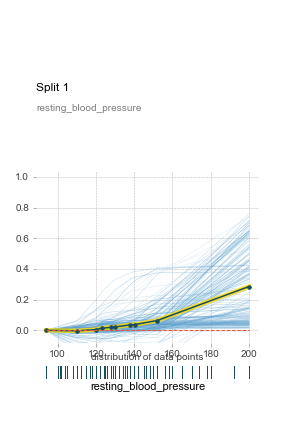
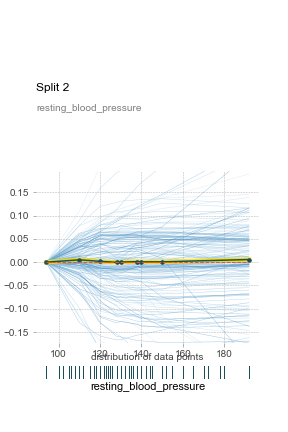
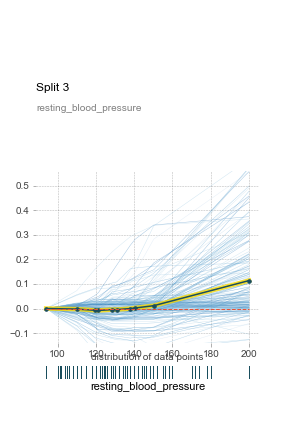
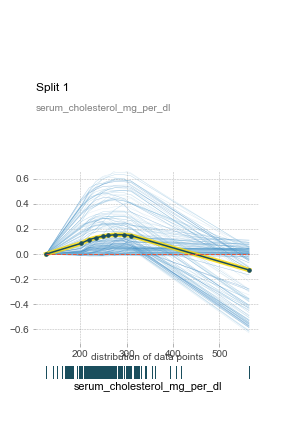
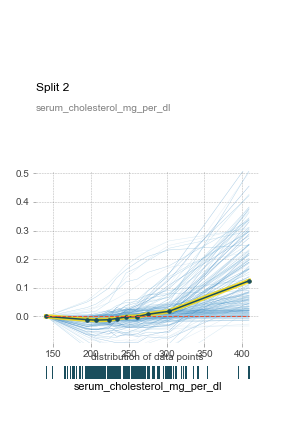
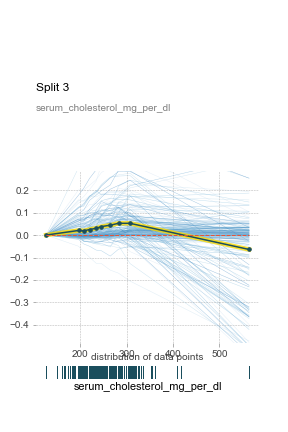
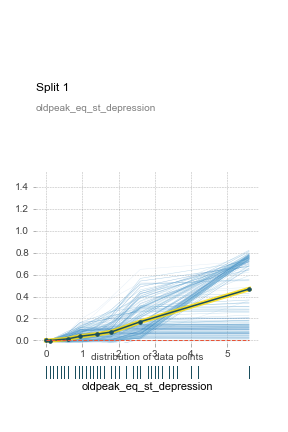
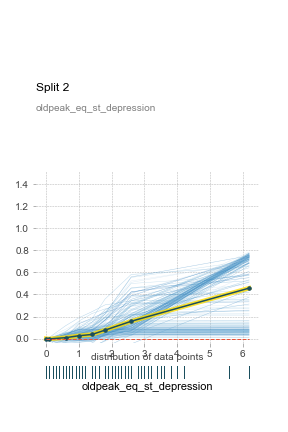
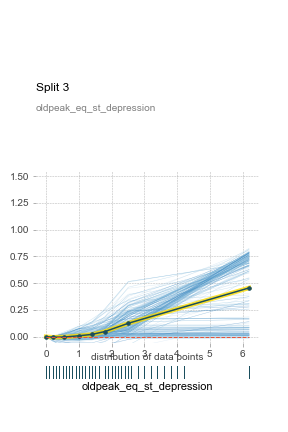
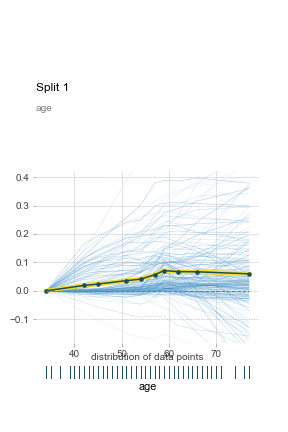
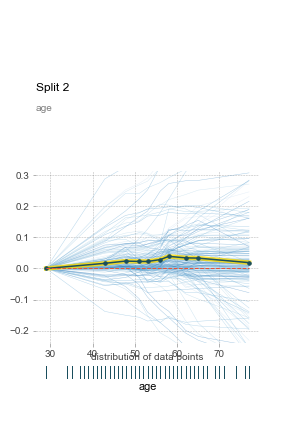
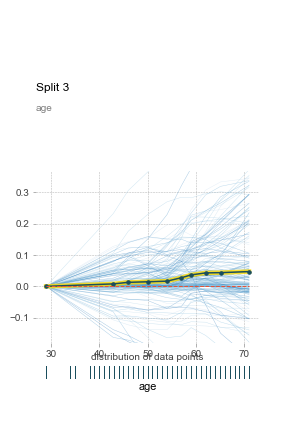
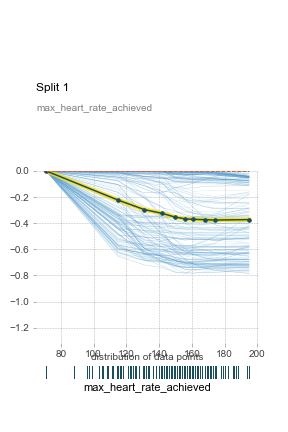
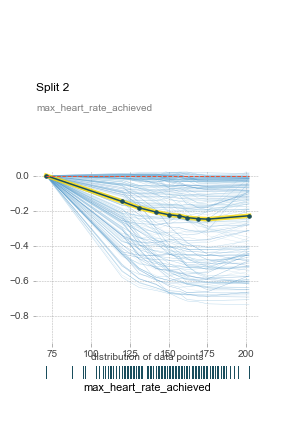
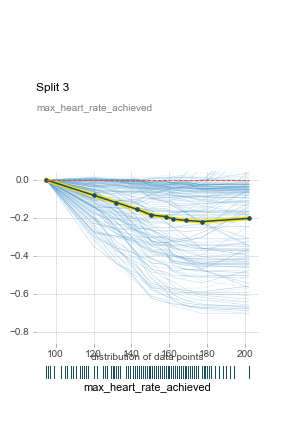

CPU times: user 17.7 s, sys: 831 ms, total: 18.5 s
Wall time: 34.3 s


In [11]:
%time plot_pdp_features_per_split(configs, numerical_column_names, ice=True)

### ICEs for categorical columns


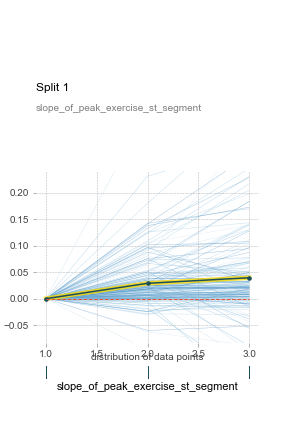
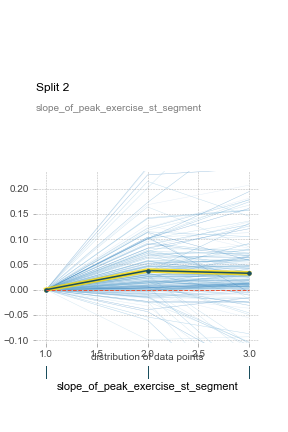
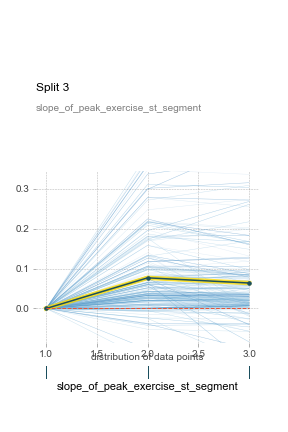
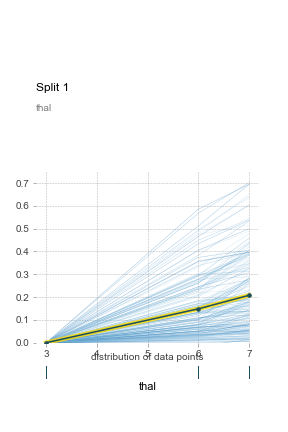
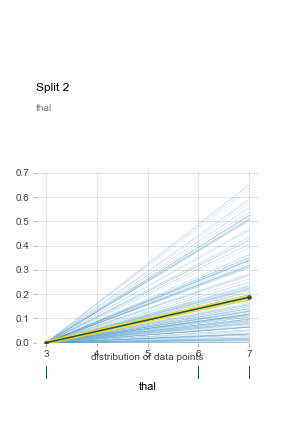
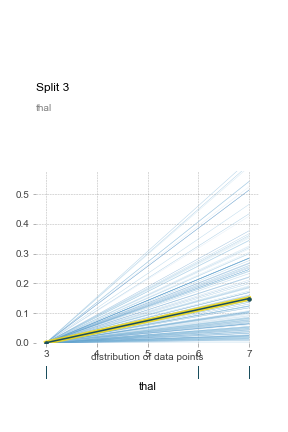
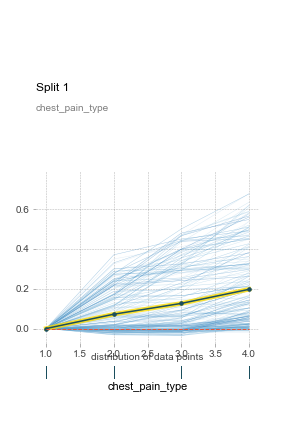
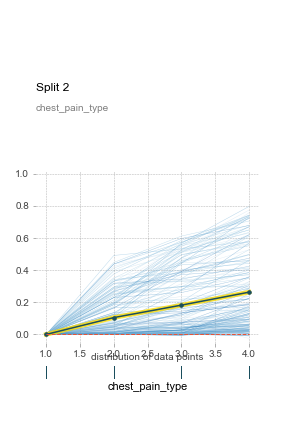
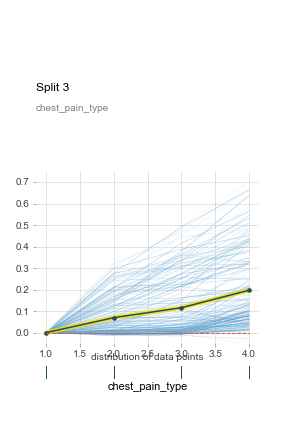
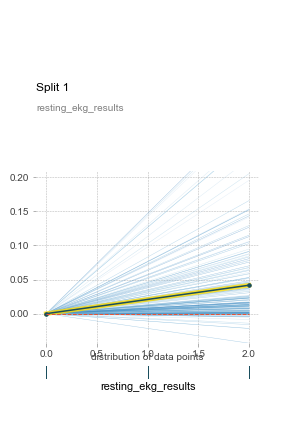
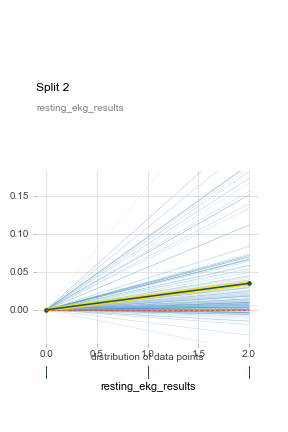
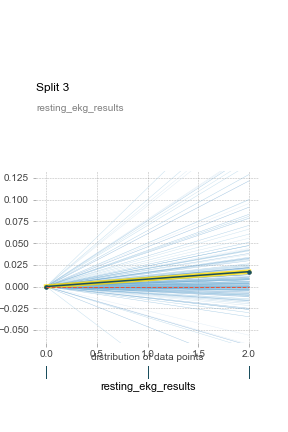
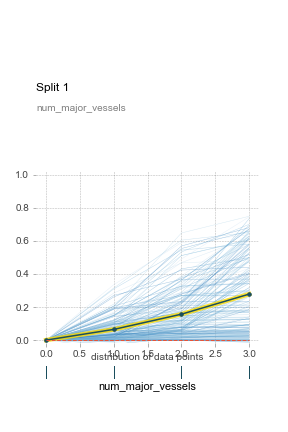
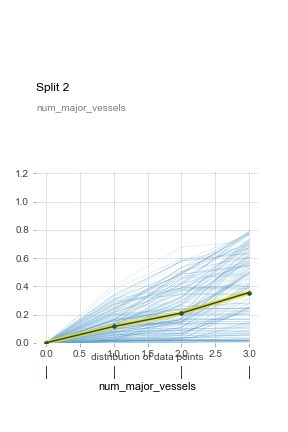
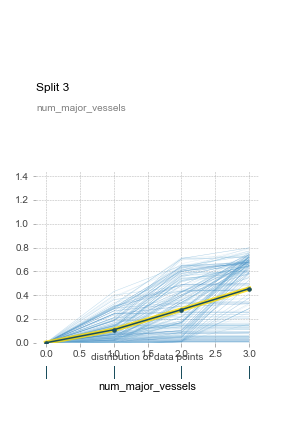

CPU times: user 13.8 s, sys: 394 ms, total: 14.2 s
Wall time: 19 s


In [12]:
%time plot_pdp_features_per_split(configs, categorical_column_names, ice=True)

### ICEs for binary columns


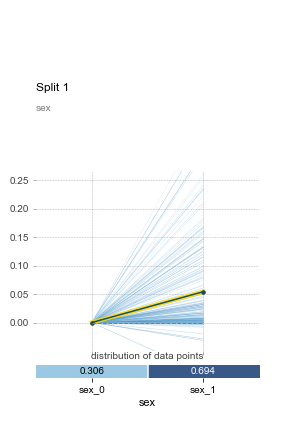
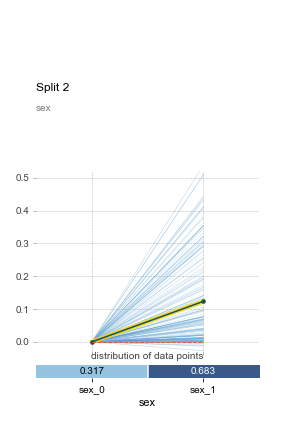
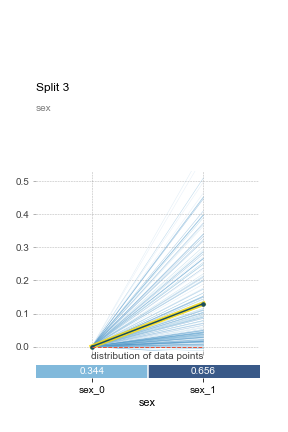
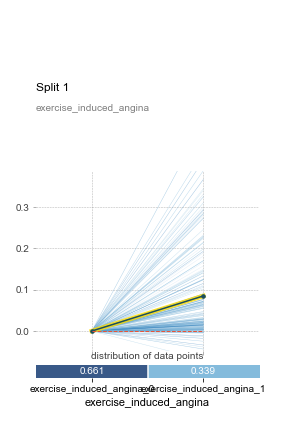
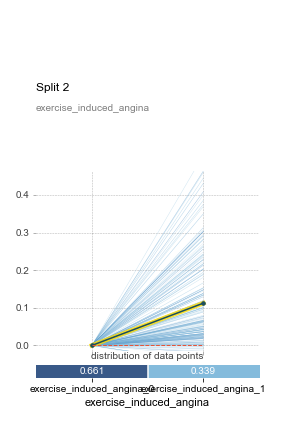
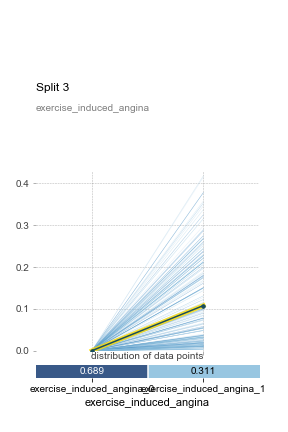
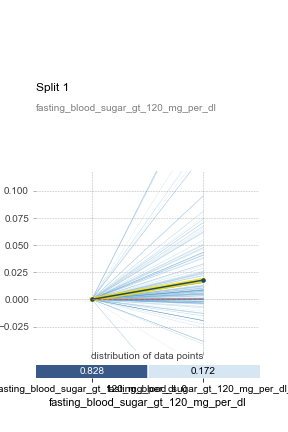
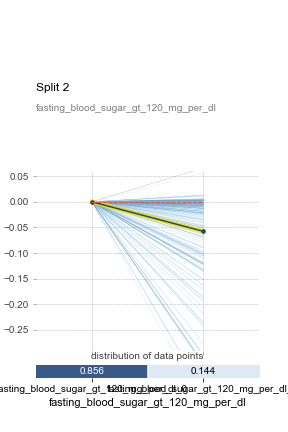
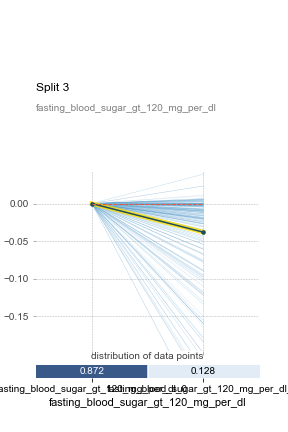

CPU times: user 7 s, sys: 148 ms, total: 7.15 s
Wall time: 9 s


In [13]:
%time plot_pdp_features_per_split(configs, binary_column_names, ice=True)

## 4. ALE

In [14]:
from lib.xai import plot_ale_features_per_split

### ALEs for numerical columns


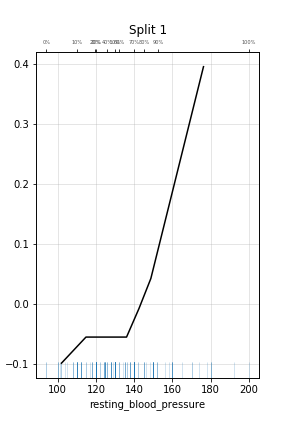
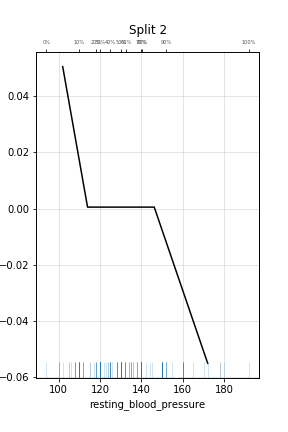
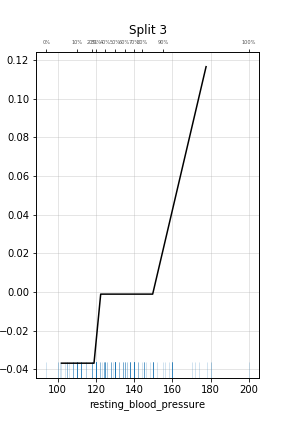
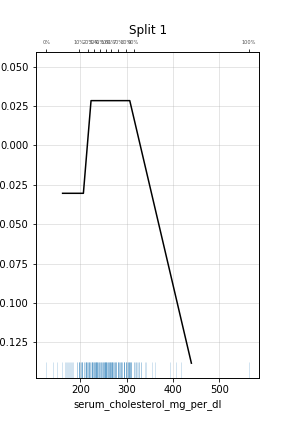
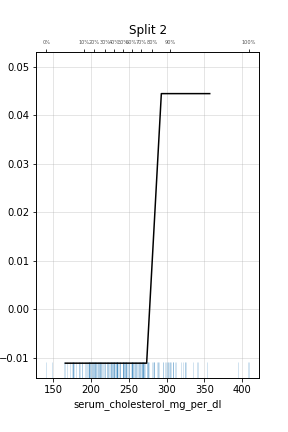
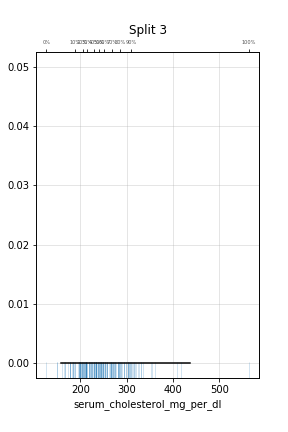
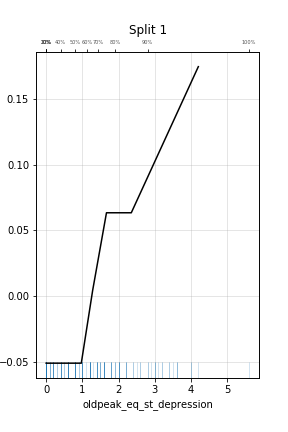
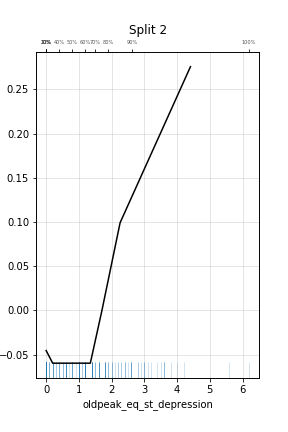
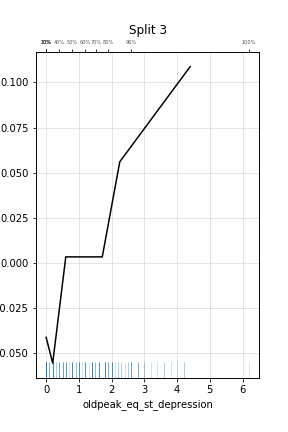
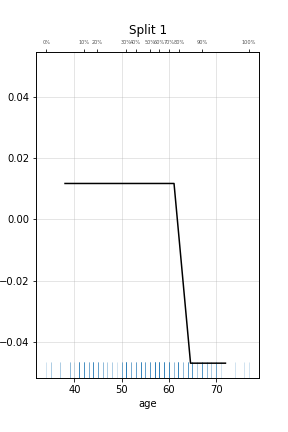
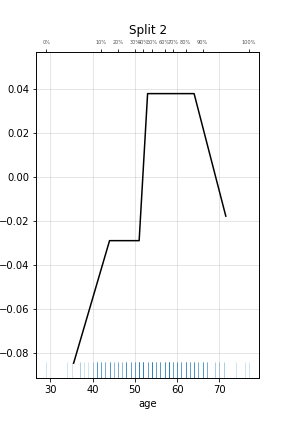
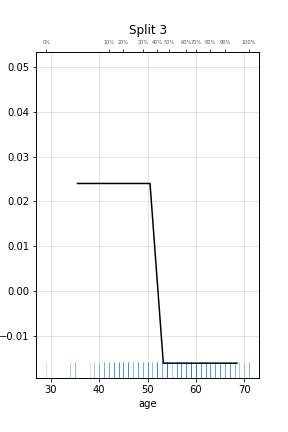
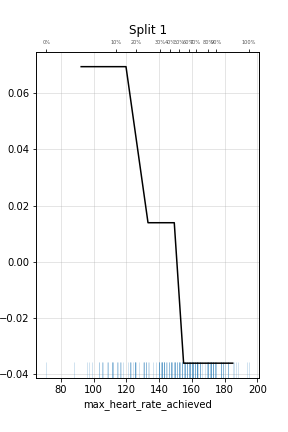
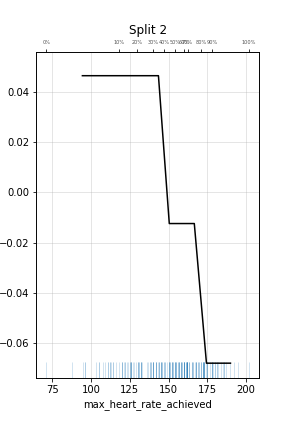
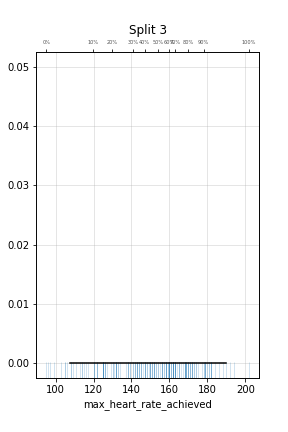

CPU times: user 9.25 s, sys: 1.16 s, total: 10.4 s
Wall time: 32.8 s


In [15]:
%time plot_ale_features_per_split(configs, numerical_column_names)

### ALEs for categorical columns


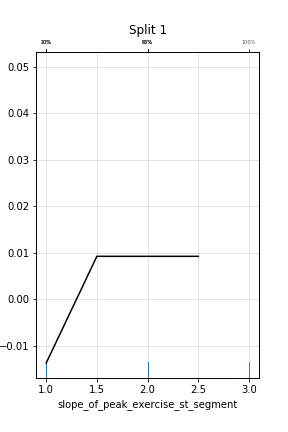
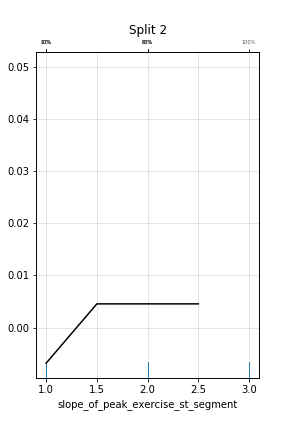
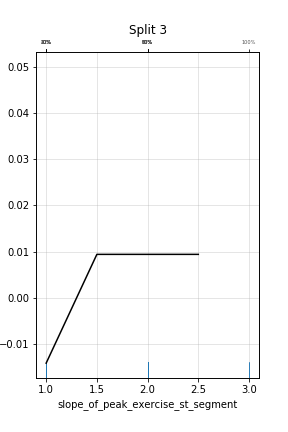
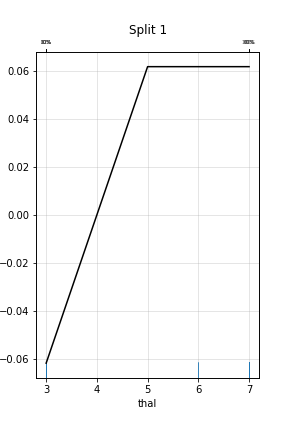
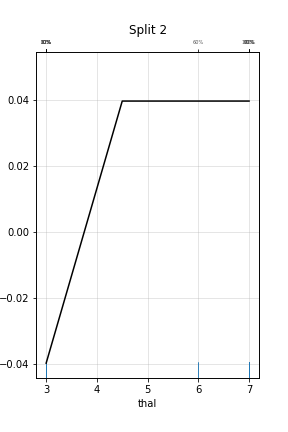
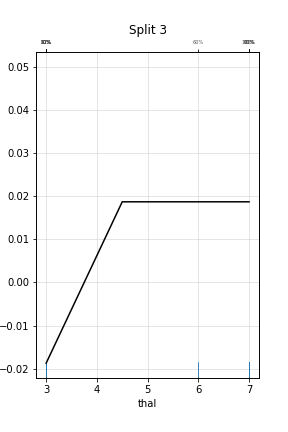
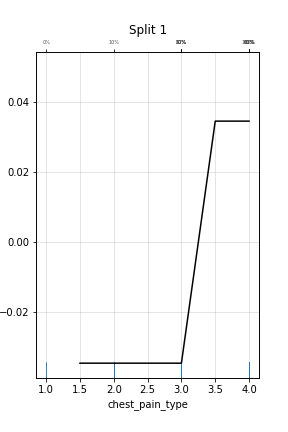
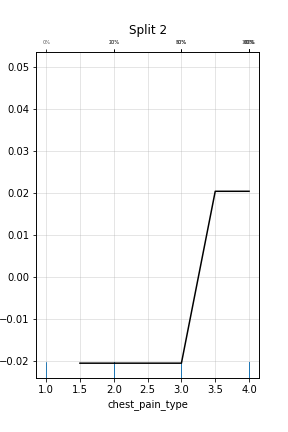
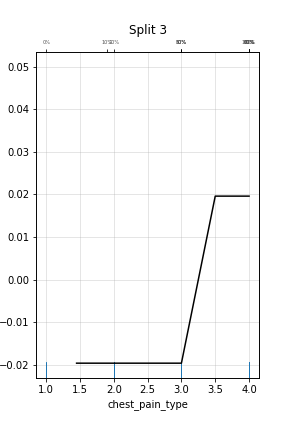
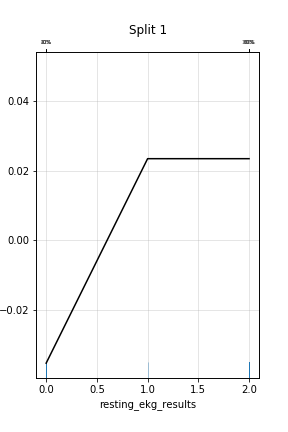
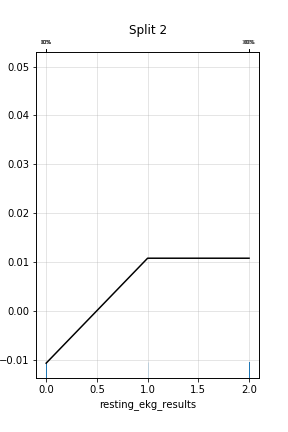
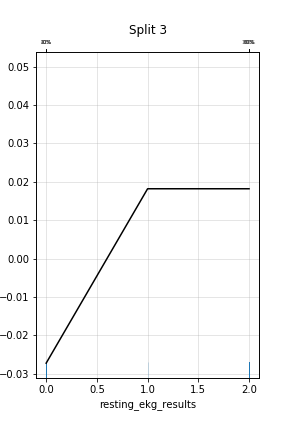
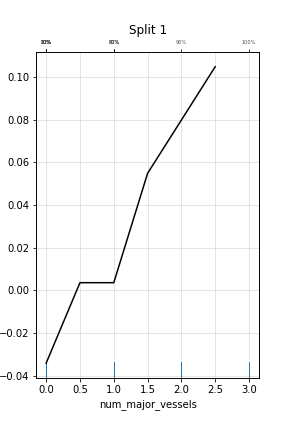
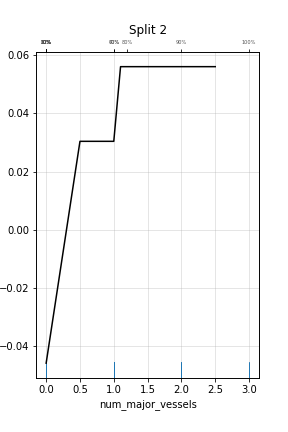
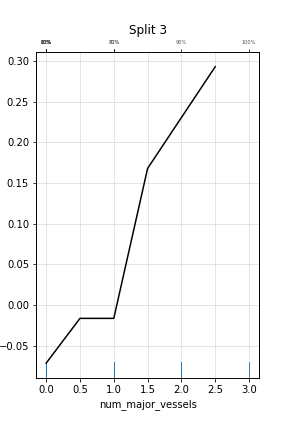

CPU times: user 5.72 s, sys: 520 ms, total: 6.24 s
Wall time: 9.7 s


In [16]:
%time plot_ale_features_per_split(configs, categorical_column_names)

### ALEs for binary columns


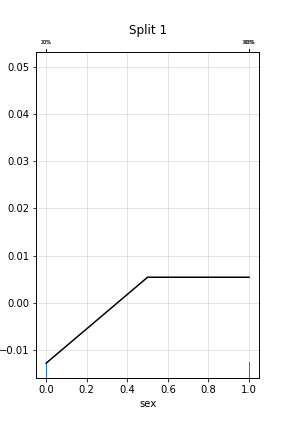
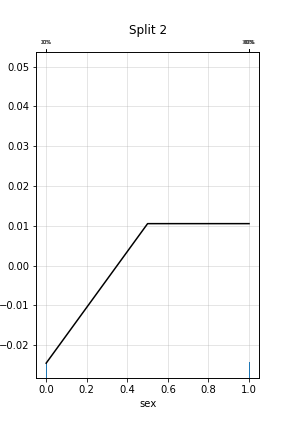
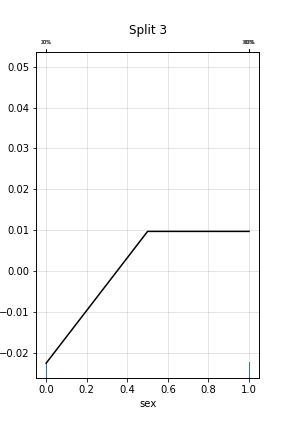
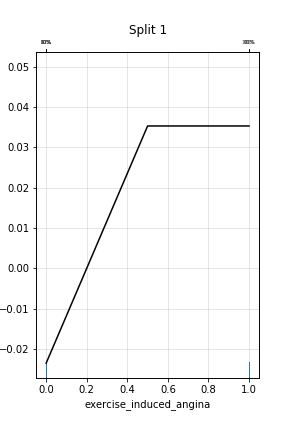
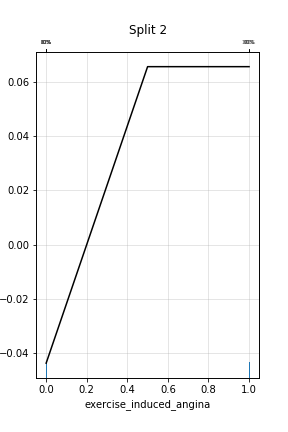
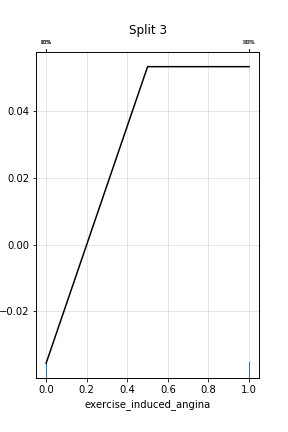
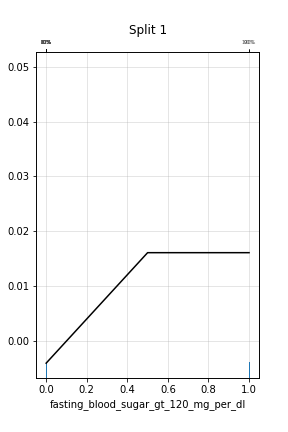
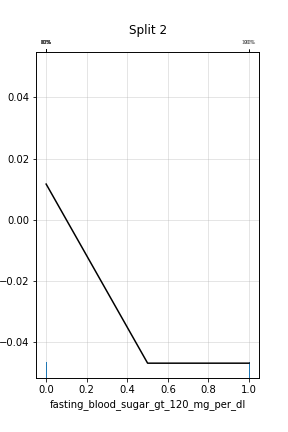
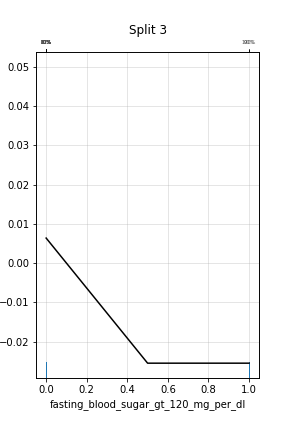

CPU times: user 3.96 s, sys: 339 ms, total: 4.3 s
Wall time: 4.58 s


In [17]:
%time plot_ale_features_per_split(configs, binary_column_names)

## 5. Surrogate Model

### 1. Train our original classifier on the full dataset and collect stats

In [18]:
from lib.xai import train_surrogate, estimator_stats

In [19]:
def get_split_stats():
    split_stats = []

    for config in configs:
        accuracy = config['score']
        original_estimator = config['estimator']
        (train_values, train_labels, val_values, val_labels) = config['data']

        train_labels_list = list(train_labels['heart_disease'].values)
        val_labels_list = list(val_labels['heart_disease'].values)

        surrogate = train_surrogate(original_estimator, train_values)

        all_labels_list = train_labels_list + val_labels_list
        all_values = pd.concat([train_values, val_values], axis=0)

        original_stats = estimator_stats(original_estimator, all_values, all_labels_list)
        surrogate_to_predictions_stats = estimator_stats(surrogate, all_values, original_stats[2])
        surrogate_to_gt_stats = estimator_stats(surrogate, all_values, all_labels_list)

        split_stats.append({
            'estimator': surrogate,
            'original': original_stats,
            'surrogate_to_predictions': surrogate_to_predictions_stats,
            'surrogate_to_gt': surrogate_to_gt_stats
        })
        
    return split_stats

In [20]:
%time split_stats = get_split_stats()

CPU times: user 222 ms, sys: 43.8 ms, total: 266 ms
Wall time: 736 ms


In [21]:
splits = ['1', '2', '3']
original_accuracy = list(map(lambda s: s['original'][0], split_stats))
surrogate_to_predictions_accuracy = list(map(lambda s: s['surrogate_to_predictions'][0], split_stats))
surrogate_to_gt_accuracy = list(map(lambda s: s['surrogate_to_gt'][0], split_stats))

df_accuracies = pd.DataFrame({
    'Split': splits * 3,
    'Accuracy On': ['Original'] * 3 + ['Surrogate2Predictions'] * 3 + ['Surrogate2GT'] * 3,
    'Accuracy Score': original_accuracy + surrogate_to_predictions_accuracy + surrogate_to_gt_accuracy
})

In [22]:
df_accuracies.set_index('Split')

Accuracy On  Accuracy Score
Split                                       
1                   Original        0.862963
2                   Original        0.874074
3                   Original        0.892593
1      Surrogate2Predictions        0.944444
2      Surrogate2Predictions        0.959259
3      Surrogate2Predictions        0.948148
1               Surrogate2GT        0.859259
2               Surrogate2GT        0.862963
3               Surrogate2GT        0.870370

### 2. Plot accuracy scores

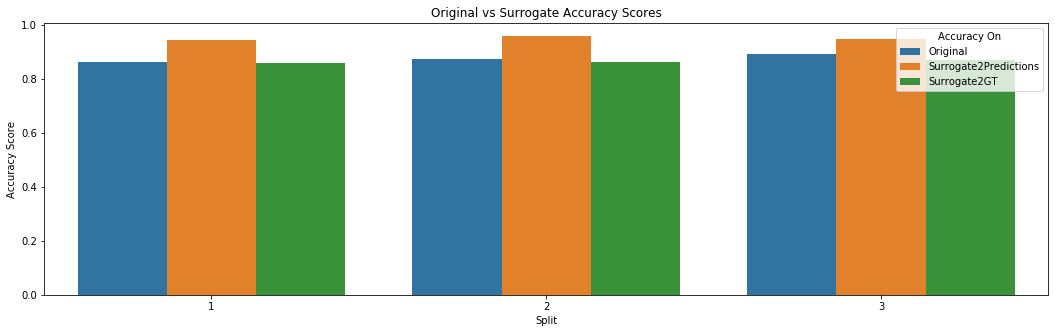

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

f, ax = plt.subplots(figsize=(18, 5))
ax = sns.barplot(x='Split', y='Accuracy Score', hue='Accuracy On', data=df_accuracies)\
        .set_title('Original vs Surrogate Accuracy Scores');

### 3. Plot confusion matrices

In [24]:
def plot_confusion_matrices(stats):
    from lib.notebook import plot_confusion_matrix
    
    cms = [stats['original'][1], stats['surrogate_to_predictions'][1], stats['surrogate_to_gt'][1]]
    cm_titles = ['Original', 'Surrogate2Predictions', 'Surrogate2GT']
    
    fig = plt.figure(figsize = (18,4))

    for i, cm in enumerate(cms):
        ax = fig.add_subplot(1, 3, i + 1)
        plot_confusion_matrix(cm, ax=ax, title=cm_titles[i])

#### Split 1

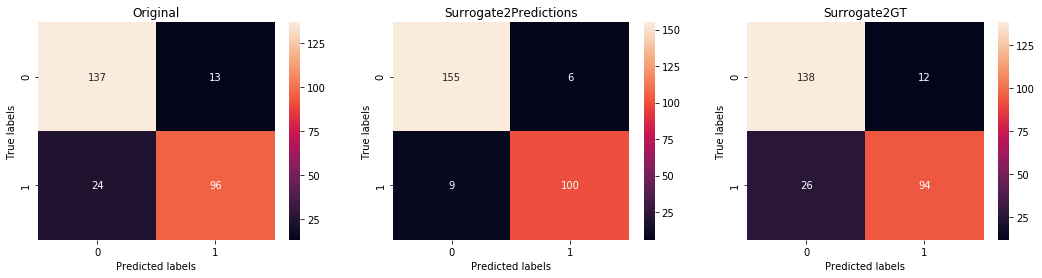

In [25]:
plot_confusion_matrices(split_stats[0])

#### Split 2

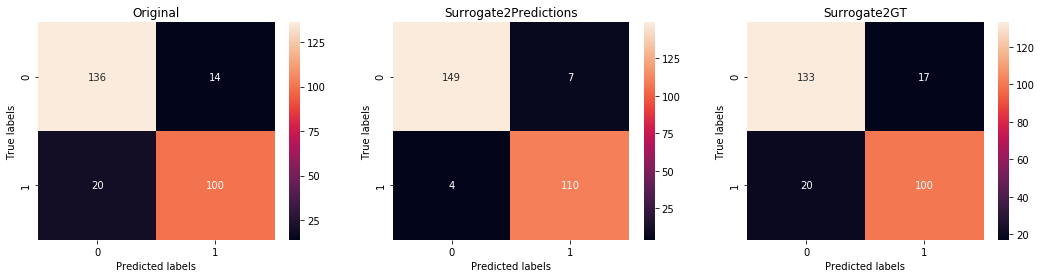

In [26]:
plot_confusion_matrices(split_stats[1])

#### Split 3

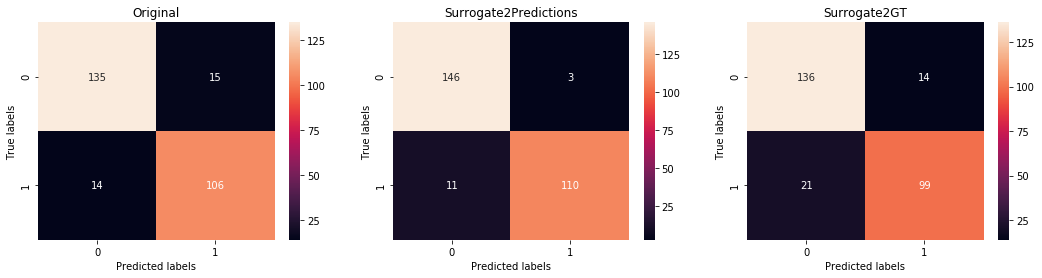

In [27]:
plot_confusion_matrices(split_stats[2])

### 6. Feature Importance

In [28]:
from lib.definitions import all_column_names

num_features = len(all_column_names) - 1

feature_coef_list = list(map(lambda s: s['estimator'].coef_.ravel(), split_stats))
feature_name_list = all_column_names[:-1]

In [29]:
split_dicts = list(map(lambda i: dict(list(zip(feature_name_list, feature_coef_list[i]))), range(3)))
for i, sd in enumerate(split_dicts):
    sd['Split'] = i + 1

In [30]:
df_splits = pd.DataFrame.from_records(split_dicts, index='Split')
df_splits = df_splits[feature_name_list].transpose()
df_splits

Split                                        1         2         3
age                                  -0.063862 -0.055226 -0.072095
sex                                   0.779867  1.003735  1.111790
chest_pain_type                       0.768554  1.034415  1.197808
resting_blood_pressure                0.049763  0.001279  0.037212
serum_cholesterol_mg_per_dl           0.000651 -0.002857  0.001251
fasting_blood_sugar_gt_120_mg_per_dl -0.013444 -0.253927 -0.267450
resting_ekg_results                   0.566557  0.487779  0.308763
max_heart_rate_achieved              -0.091047 -0.058455 -0.086072
exercise_induced_angina               1.719827  1.276042  1.580388
oldpeak_eq_st_depression              0.905475  1.187879  1.198756
slope_of_peak_exercise_st_segment     0.099547  0.053827  0.586763
num_major_vessels                     2.051977  2.272763  1.780792
thal                                  0.823640  0.989480  0.692314

In [31]:
splits = ['1'] * num_features + ['2'] * num_features + ['3'] * num_features
feature_names = feature_name_list * 3
feature_coefs = np.concatenate(feature_coef_list)

df_feature_importances = pd.DataFrame({
    'Split': splits,
    'Feature': feature_names,
    'Importance': feature_coefs
})

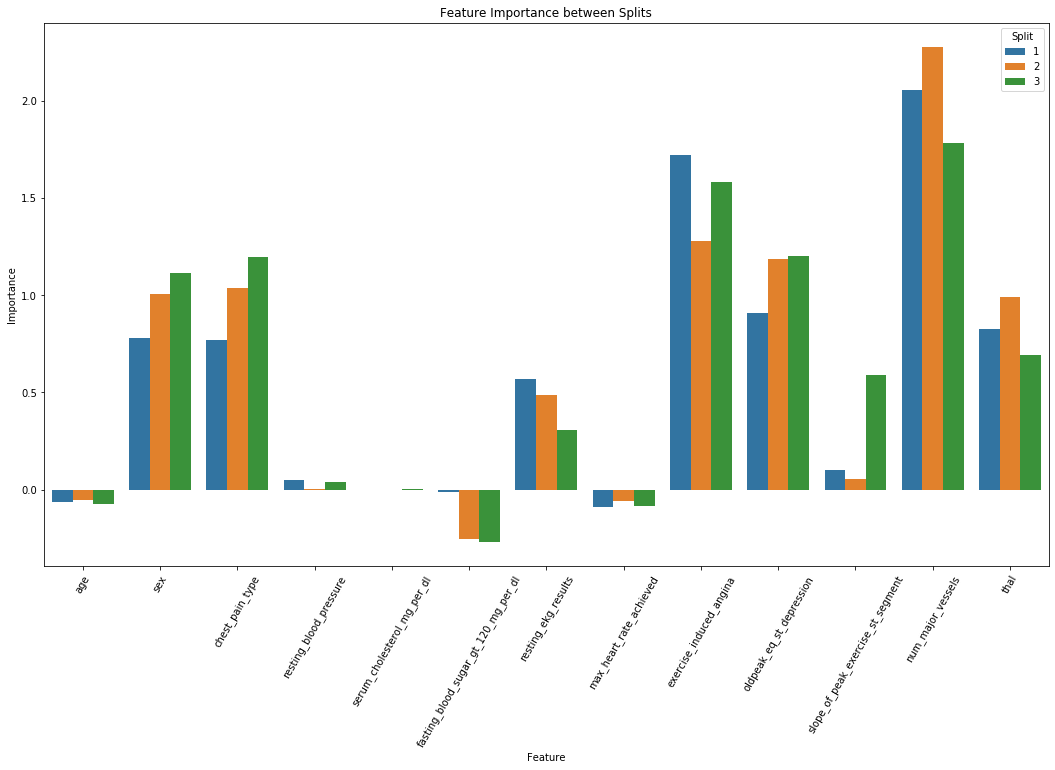

In [32]:
f, ax = plt.subplots(figsize=(18, 10))
ax = sns.barplot(x='Feature', y='Importance', hue='Split', data=df_feature_importances);

for item in ax.get_xticklabels():
    item.set_rotation(60)
    
ax.set_title('Feature Importance between Splits');

## 6. Counterfactural Example

In [33]:
def find_examples(features, labels_list):
    from sklearn.neighbors import NearestCentroid
    from sklearn.neighbors import KNeighborsClassifier
    
    nc = NearestCentroid()
    nc = nc.fit(features, labels_list)
    
    centroids = nc.centroids_
    
    knn = KNeighborsClassifier(n_jobs=-1)
    knn = knn.fit(features, labels_list)
    
    results = []
    
    for c in [0, 1]:
        centroid = centroids[c]
        
        distances, indices = knn.kneighbors([centroid], 100)
        
        top_labels = labels_list[indices[0]]
        
        prototype_idx = np.argwhere(top_labels == c)[0][0]
        counterfactual_idx = np.argwhere(top_labels == np.abs(c-1))[0][0]
        
        results.append([
            (distances[0][prototype_idx], indices[0][prototype_idx]),
            (distances[0][counterfactual_idx], indices[0][counterfactual_idx])
        ])
        
    return results

def find_examples_per_split(configs):
    split_examples = []

    for config in configs:
        estimator = config['estimator']
        (train_values, train_labels, val_values, val_labels) = config['data']
    
        predictions = estimator.predict(train_values)
    
        examples = find_examples(train_values, predictions)

        negative = examples[0]
        positive = examples[1]
    
        split_example = []
    
        for example in examples:
            prototype_dist, prototype_idx = example[0]
            counterfactural_dist, counterfactural_idx = example[1]

            split_example.append({
                'prototype': {
                    'distance': prototype_dist,
                    'index':  prototype_idx,
                    'row': train_values.iloc[prototype_idx]
                },
                'counterfactual': {
                    'distance': counterfactural_dist,
                    'index':  counterfactural_idx,
                    'row': train_values.iloc[counterfactural_idx]
                }
            })

        split_examples.append(split_example)
        
    return split_examples

def example_df_for_split(split_example):
            
    def entry_rows(entry, target):
        prototype_row = entry['prototype']['row']
        counterfactual_row = entry['counterfactual']['row']
        
        prototype_row['Distance'] = entry['prototype']['distance']
        prototype_row['Type'] = 'Prototype'
        prototype_row['Disease Present'] = target
        
        counterfactual_row['Distance'] = entry['counterfactual']['distance']
        counterfactual_row['Type'] = 'Counterfactual'
        counterfactual_row['Disease Present'] = target
    
        return [prototype_row.to_dict(), counterfactual_row.to_dict()]
        
        
    examples = []

    negative = split_example[0]
    positive = split_example[1]
        
    examples += entry_rows(negative, 'NO')
    examples += entry_rows(positive, 'YES')

    df = pd.DataFrame.from_records(examples)
    df.set_index(['Disease Present', 'Type'], inplace=True)
    return df.transpose()

In [34]:
%time split_examples = find_examples_per_split(configs)

CPU times: user 130 ms, sys: 25 ms, total: 155 ms
Wall time: 1.02 s


### Examples for Split 1

In [35]:
%time example_df_for_split(split_examples[0])

CPU times: user 19 ms, sys: 2.29 ms, total: 21.3 ms
Wall time: 21.7 ms


Disease Present                               NO                        YES  \
Type                                   Prototype Counterfactual   Prototype   
Distance                                7.711355       5.892453   11.095252   
age                                    55.000000      52.000000   58.000000   
chest_pain_type                         2.000000       4.000000    4.000000   
exercise_induced_angina                 0.000000       1.000000    1.000000   
fasting_blood_sugar_gt_120_mg_per_dl    0.000000       0.000000    0.000000   
max_heart_rate_achieved               161.000000     161.000000  130.000000   
num_major_vessels                       0.000000       1.000000    2.000000   
oldpeak_eq_st_depression                1.400000       0.000000    3.000000   
resting_blood_pressure                135.000000     128.000000  128.000000   
resting_ekg_results                     2.000000       0.000000    2.000000   
serum_cholesterol_mg_per_dl           250.000000     255.000000  259.000000   
sex                                     0.000000       1.000000    1.000000   
slope_of_peak_exercise_st_segment       2.000000       1.000000    2.000000   
thal                                    3.000000       7.000000    7.000000   

Disease Present                                      
Type                                 Counterfactual  
Distance                                  11.611035  
age                                       53.000000  
chest_pain_type                            4.000000  
exercise_induced_angina                    0.000000  
fasting_blood_sugar_gt_120_mg_per_dl       0.000000  
max_heart_rate_achieved                  143.000000  
num_major_vessels                          0.000000  
oldpeak_eq_st_depression                   0.400000  
resting_blood_pressure                   130.000000  
resting_ekg_results                        2.000000  
serum_cholesterol_mg_per_dl              264.000000  
sex                                        0.000000  
slope_of_peak_exercise_st_segment          2.000000  
thal                                       3.000000

### Examples for Split 2

In [36]:
%time example_df_for_split(split_examples[1])

CPU times: user 37.7 ms, sys: 3.97 ms, total: 41.6 ms
Wall time: 41.3 ms


Disease Present                               NO                       YES  \
Type                                   Prototype Counterfactual  Prototype   
Distance                                8.491109      12.600799    9.23632   
age                                    51.000000      52.000000   60.00000   
chest_pain_type                         3.000000       4.000000    4.00000   
exercise_induced_angina                 0.000000       1.000000    1.00000   
fasting_blood_sugar_gt_120_mg_per_dl    1.000000       0.000000    0.00000   
max_heart_rate_achieved               166.000000     161.000000  144.00000   
num_major_vessels                       0.000000       1.000000    1.00000   
oldpeak_eq_st_depression                2.400000       0.000000    1.40000   
resting_blood_pressure                125.000000     128.000000  130.00000   
resting_ekg_results                     2.000000       0.000000    0.00000   
serum_cholesterol_mg_per_dl           245.000000     255.000000  253.00000   
sex                                     1.000000       1.000000    1.00000   
slope_of_peak_exercise_st_segment       2.000000       1.000000    1.00000   
thal                                    3.000000       7.000000    7.00000   

Disease Present                                      
Type                                 Counterfactual  
Distance                                  18.469687  
age                                       61.000000  
chest_pain_type                            3.000000  
exercise_induced_angina                    1.000000  
fasting_blood_sugar_gt_120_mg_per_dl       1.000000  
max_heart_rate_achieved                  137.000000  
num_major_vessels                          0.000000  
oldpeak_eq_st_depression                   1.000000  
resting_blood_pressure                   150.000000  
resting_ekg_results                        0.000000  
serum_cholesterol_mg_per_dl              243.000000  
sex                                        1.000000  
slope_of_peak_exercise_st_segment          2.000000  
thal                                       3.000000

### Examples for Split 3

In [37]:
%time example_df_for_split(split_examples[2])

CPU times: user 28.5 ms, sys: 3.77 ms, total: 32.3 ms
Wall time: 33.1 ms


Disease Present                               NO                        YES  \
Type                                   Prototype Counterfactual   Prototype   
Distance                                9.995048      17.536697   12.818749   
age                                    50.000000      50.000000   56.000000   
chest_pain_type                         2.000000       3.000000    4.000000   
exercise_induced_angina                 0.000000       0.000000    1.000000   
fasting_blood_sugar_gt_120_mg_per_dl    0.000000       0.000000    1.000000   
max_heart_rate_achieved               162.000000     163.000000  144.000000   
num_major_vessels                       0.000000       1.000000    1.000000   
oldpeak_eq_st_depression                1.100000       0.600000    1.200000   
resting_blood_pressure                120.000000     140.000000  125.000000   
resting_ekg_results                     0.000000       0.000000    2.000000   
serum_cholesterol_mg_per_dl           244.000000     233.000000  249.000000   
sex                                     0.000000       1.000000    1.000000   
slope_of_peak_exercise_st_segment       1.000000       2.000000    2.000000   
thal                                    3.000000       7.000000    3.000000   

Disease Present                                      
Type                                 Counterfactual  
Distance                                  17.273754  
age                                       51.000000  
chest_pain_type                            3.000000  
exercise_induced_angina                    0.000000  
fasting_blood_sugar_gt_120_mg_per_dl       0.000000  
max_heart_rate_achieved                  149.000000  
num_major_vessels                          0.000000  
oldpeak_eq_st_depression                   0.500000  
resting_blood_pressure                   130.000000  
resting_ekg_results                        2.000000  
serum_cholesterol_mg_per_dl              256.000000  
sex                                        0.000000  
slope_of_peak_exercise_st_segment          1.000000  
thal                                       3.000000